0    54.28
1    54.44
2    53.99
3    52.59
4    51.68
Name: Price, dtype: float64


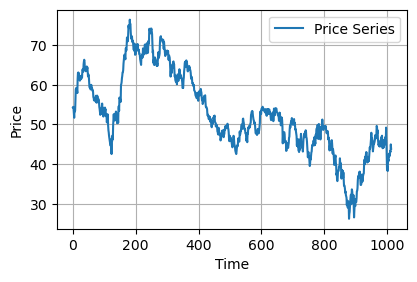

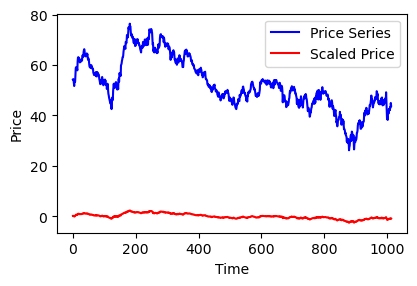

dfOil shape= (1014, 2).
dfOilPriceScaled shape= (1014, 1).
oilPX shape== (1000, 14, 1).
oilPY shape== (1000, 1).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 7s 40ms/step - loss:

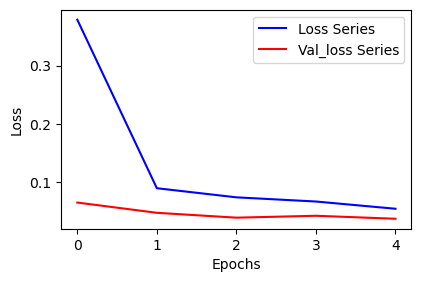

1/1 [==============================] - 1s 696ms/step


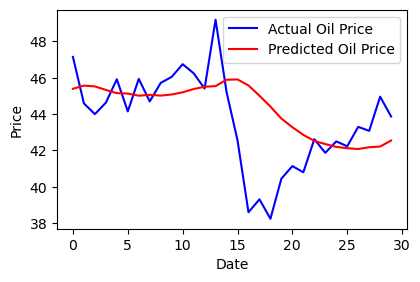

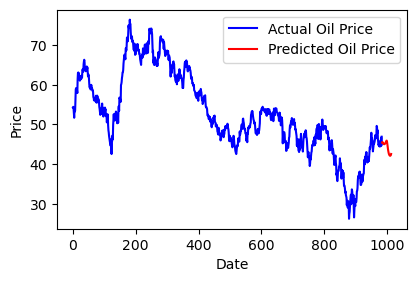

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
import os

def plotCurve(x,y,xlable,ylabel,clabel):
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x,y,label=clabel)
    ax.set_xlabel(xlable)
    ax.set_ylabel(ylabel)
    plt.grid()
    ax.legend()
    plt.show()

def plotTwoCurves(x1,x2,y1,y2,xlable,ylabel,clabel1,clabel2):
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(bottom=0.15, left=0.2)
    ax.plot(x1,y1,color='blue',label=clabel1)
    ax.plot(x2,y2,color='red',label=clabel2)
    ax.set_xlabel(xlable)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()

dfOil=pd.read_csv('Crude Oil WTI3.csv')
dfOil['Date']=pd.to_datetime(dfOil['Date'])
print(dfOil['Price'].head())

index1=range(0,dfOil['Date'].shape[0])

plotCurve(index1,dfOil['Price'],'Time','Price','Price Series')

dfOilPrice=dfOil['Price'].astype(float)

scaler=StandardScaler()
# scaler=MinMaxScaler()
scaler=scaler.fit(dfOilPrice.values.reshape(-1, 1))
dfOilPriceScaled=scaler.transform(dfOilPrice.values.reshape(-1, 1))

plotTwoCurves(index1,index1,dfOil['Price'],dfOilPriceScaled,'Time','Price','Price Series','Scaled Price')

oilPX=[]
oilPY=[]

nextPrd=1
windSz=14

for i in range(windSz, len(dfOilPriceScaled)-nextPrd+1):    
    oilPX.append(dfOilPriceScaled[i-windSz:i])
    oilPY.append(dfOilPriceScaled[i+nextPrd-1:i+nextPrd,0])

oilPX,oilPY=np.array(oilPX),np.array(oilPY)

print('dfOil shape= {}.'.format(dfOil.shape))
print('dfOilPriceScaled shape= {}.'.format(dfOilPriceScaled.shape))
print('oilPX shape== {}.'.format(oilPX.shape))
print('oilPY shape== {}.'.format(oilPY.shape))

model=Sequential()
model.add(LSTM(100, activation='relu', input_shape=(oilPX.shape[1], oilPX.shape[2]), return_sequences=True))
model.add(LSTM(50, activation= 'relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(oilPY.shape[1]))

model.compile(optimizer='adam',loss='mse')

model.summary()

history=model.fit(oilPX,oilPY,epochs=5,batch_size=16, validation_split=0.1,verbose=1)

index2=range(0,len(history.history['loss']))
plotTwoCurves(index2,index2,history.history['loss'],history.history['val_loss'],'Epochs','Loss','Loss Series','Val_loss Series')

forecastD=30

predictedForDays=model.predict(oilPX[-forecastD:])

predictedForDaysInn=scaler.inverse_transform(predictedForDays)
index3=range(0,len(predictedForDaysInn))
plotTwoCurves(index3,index3,dfOil['Price'][-forecastD:],predictedForDaysInn,'Date','Price','Actual Oil Price','Predicted Oil Price')


index4=range(0,len(dfOil)-forecastD)
index5=range(len(dfOil)-forecastD,len(dfOil))
plotTwoCurves(index4,index5,dfOil['Price'][0:len(dfOil)-forecastD],predictedForDaysInn,'Date','Price','Actual Oil Price','Predicted Oil Price')